# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   land_speed              1206 non-null   float64
 1   num_immunities          1206 non-null   int64  
 2   ac                      1206 non-null   int64  
 3   wis                     1206 non-null   int64  
 4   hp                      1206 non-null   int64  
 5   con                     1206 non-null   int64  
 6   reflex                  1206 non-null   int64  
 7   int                     1206 non-null   int64  
 8   book                    1206 non-null   object 
 9   focus                   1206 non-null   int32  
 10  will                    1206 non-null   int64  
 11  perception              1206 non-null   int64  
 12  level                   1206 non-null   int64  
 13  str                     1206 non-null   int64  
 14  dex                     1206 non-null   

In [3]:
df.head()

,land_speed,num_immunities,ac,wis,hp,con,reflex,int,book,focus,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,30.0,3,29,2,215,5,19,1,Pathfinder Bestiary,1,...,0,0,0,0,0,0,23,22.0,0,0.0
1,35.0,0,28,2,220,5,14,-4,Pathfinder Bestiary,0,...,0,0,0,0,0,0,23,22.0,0,0.0
2,30.0,0,25,3,175,6,17,-4,Pathfinder Bestiary,0,...,0,0,0,0,0,0,21,16.0,0,0.0
3,50.0,3,41,5,315,5,29,6,Pathfinder Bestiary,1,...,1,0,1,0,0,0,33,31.5,0,0.0
4,0.0,0,16,1,20,1,10,-1,Pathfinder Bestiary,1,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


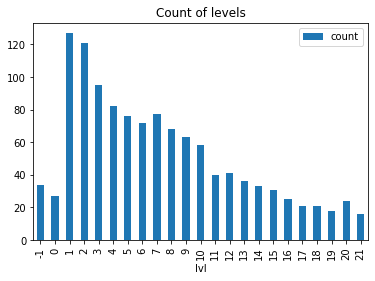

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[88]	valid_0's l1: 0.463517	valid_0's l2: 0.932502


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.97
MAE: 0.46


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.13
RMSE test: 0.97


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

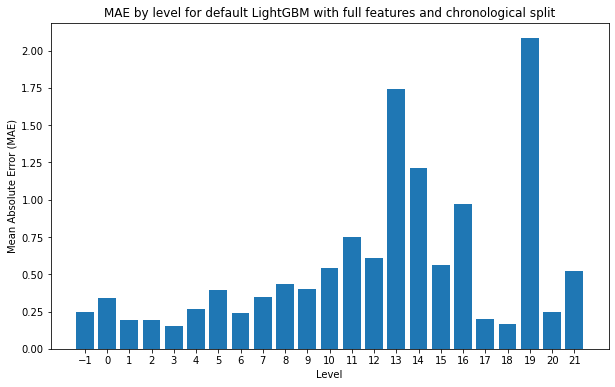

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.97

Round type: round
RMSE: 0.98

Round type: 0.33
RMSE: 0.96

Round type: 0.45
RMSE: 0.96



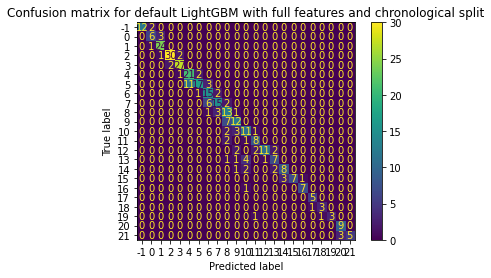

In [20]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with full features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 12:40:08,955] A new study created in memory with name: no-name-3aee44e3-8c20-4797-8516-2531890c5dd9
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.147165 + 0.0304089
[200]	cv_agg's l2: 0.143698 + 0.02958
[300]	cv_agg's l2: 0.142047 + 0.0283975
[400]	cv_agg's l2: 0.141423 + 0.0281346
[500]	cv_agg's l2: 0.141255 + 0.0282385
[600]	cv_agg's l2: 0.141035 + 0.0280663
[700]	cv_agg's l2: 0.140958 + 0.0280362
[800]	cv_agg's l2: 0.140931 + 0.0280483
[900]	cv_agg's l2: 0.140897 + 0.0279579


feature_fraction, val_score: 0.140872:  14%|######4                                      | 1/7 [00:17<01:46, 17.72s/it]

Early stopping, best iteration is:
[852]	cv_agg's l2: 0.140872 + 0.0279681
[100]	cv_agg's l2: 0.151393 + 0.0376705
[200]	cv_agg's l2: 0.149682 + 0.0372732
[300]	cv_agg's l2: 0.148999 + 0.0373818
[400]	cv_agg's l2: 0.14885 + 0.0376309
[500]	cv_agg's l2: 0.148963 + 0.0379128
[600]	cv_agg's l2: 0.148957 + 0.0379075
[700]	cv_agg's l2: 0.149061 + 0.037818
[800]	cv_agg's l2: 0.149212 + 0.0378339
[900]	cv_agg's l2: 0.149262 + 0.037718


feature_fraction, val_score: 0.140872:  29%|############8                                | 2/7 [00:39<01:39, 19.91s/it]

Early stopping, best iteration is:
[852]	cv_agg's l2: 0.140872 + 0.0279681
[100]	cv_agg's l2: 0.135333 + 0.0241253
[200]	cv_agg's l2: 0.131246 + 0.0232086
[300]	cv_agg's l2: 0.130922 + 0.0237165
[400]	cv_agg's l2: 0.130607 + 0.0238819


feature_fraction, val_score: 0.130514:  43%|###################2                         | 3/7 [00:47<00:58, 14.56s/it]

Early stopping, best iteration is:
[350]	cv_agg's l2: 0.130514 + 0.0236286
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893


feature_fraction, val_score: 0.126672:  57%|#########################7                   | 4/7 [00:56<00:37, 12.43s/it]

Early stopping, best iteration is:
[372]	cv_agg's l2: 0.126672 + 0.0262447
[100]	cv_agg's l2: 0.143287 + 0.0251992
[200]	cv_agg's l2: 0.139024 + 0.0252343
[300]	cv_agg's l2: 0.136816 + 0.0248923
[400]	cv_agg's l2: 0.136185 + 0.0252706


feature_fraction, val_score: 0.126672:  71%|################################1            | 5/7 [01:05<00:22, 11.01s/it]

Early stopping, best iteration is:
[372]	cv_agg's l2: 0.126672 + 0.0262447
[100]	cv_agg's l2: 0.144141 + 0.0316979
[200]	cv_agg's l2: 0.14156 + 0.0314114
[300]	cv_agg's l2: 0.141729 + 0.0315731
[400]	cv_agg's l2: 0.141712 + 0.0314676


feature_fraction, val_score: 0.126672:  86%|######################################5      | 6/7 [01:13<00:10, 10.15s/it]

Early stopping, best iteration is:
[372]	cv_agg's l2: 0.126672 + 0.0262447
[100]	cv_agg's l2: 0.147013 + 0.0330895
[200]	cv_agg's l2: 0.144666 + 0.0329384
[300]	cv_agg's l2: 0.143901 + 0.0323946
[400]	cv_agg's l2: 0.143583 + 0.0322806


feature_fraction, val_score: 0.126672: 100%|#############################################| 7/7 [01:22<00:00, 11.85s/it]


Early stopping, best iteration is:
[372]	cv_agg's l2: 0.126672 + 0.0262447


num_leaves, val_score: 0.126672:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893


num_leaves, val_score: 0.126672:   5%|##5                                               | 1/20 [00:09<03:01,  9.57s/it]

Early stopping, best iteration is:
[372]	cv_agg's l2: 0.126672 + 0.0262447
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893


num_leaves, val_score: 0.126672:  10%|#####                                             | 2/20 [00:19<02:55,  9.76s/it]

Early stopping, best iteration is:
[372]	cv_agg's l2: 0.126672 + 0.0262447
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893


num_leaves, val_score: 0.126672:  15%|#######5                                          | 3/20 [00:28<02:44,  9.65s/it]

Early stopping, best iteration is:
[372]	cv_agg's l2: 0.126672 + 0.0262447
[100]	cv_agg's l2: 0.135595 + 0.0213965
[200]	cv_agg's l2: 0.127612 + 0.0222829
[300]	cv_agg's l2: 0.125468 + 0.0227007
[400]	cv_agg's l2: 0.125044 + 0.022116
[500]	cv_agg's l2: 0.12461 + 0.0218206
[600]	cv_agg's l2: 0.124374 + 0.022036
[700]	cv_agg's l2: 0.12426 + 0.0220878


num_leaves, val_score: 0.124135:  20%|##########                                        | 4/20 [00:35<02:14,  8.39s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.164784 + 0.0187537
[200]	cv_agg's l2: 0.148064 + 0.0165883
[300]	cv_agg's l2: 0.142957 + 0.0174007
[400]	cv_agg's l2: 0.138935 + 0.0171631
[500]	cv_agg's l2: 0.137764 + 0.0167903
[600]	cv_agg's l2: 0.136537 + 0.0170014


num_leaves, val_score: 0.124135:  25%|############5                                     | 5/20 [00:39<01:41,  6.74s/it]

[700]	cv_agg's l2: 0.136402 + 0.0176825
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.164784 + 0.0187537
[200]	cv_agg's l2: 0.148064 + 0.0165883
[300]	cv_agg's l2: 0.142957 + 0.0174007
[400]	cv_agg's l2: 0.138935 + 0.0171631
[500]	cv_agg's l2: 0.137764 + 0.0167903
[600]	cv_agg's l2: 0.136537 + 0.0170014


num_leaves, val_score: 0.124135:  30%|###############                                   | 6/20 [00:44<01:28,  6.31s/it]

[700]	cv_agg's l2: 0.136402 + 0.0176825
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  35%|#################5                                | 7/20 [00:57<01:51,  8.54s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  40%|####################                              | 8/20 [01:11<02:02, 10.18s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  45%|######################5                           | 9/20 [01:25<02:05, 11.42s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  50%|########################5                        | 10/20 [01:39<02:01, 12.17s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  55%|##########################9                      | 11/20 [01:52<01:51, 12.36s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  60%|#############################4                   | 12/20 [02:05<01:41, 12.67s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  65%|###############################8                 | 13/20 [02:19<01:31, 13.03s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  70%|##################################3              | 14/20 [02:32<01:18, 13.03s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  75%|####################################7            | 15/20 [02:48<01:09, 13.90s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  80%|#######################################2         | 16/20 [03:04<00:57, 14.39s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  85%|#########################################6       | 17/20 [03:15<00:40, 13.38s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  90%|############################################1    | 18/20 [03:24<00:24, 12.23s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135:  95%|##############################################5  | 19/20 [03:33<00:11, 11.36s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.131847 + 0.0273334
[200]	cv_agg's l2: 0.128352 + 0.0269428
[300]	cv_agg's l2: 0.127225 + 0.0264705
[400]	cv_agg's l2: 0.126764 + 0.0262893
[500]	cv_agg's l2: 0.126675 + 0.0262378
[600]	cv_agg's l2: 0.126563 + 0.0262239
[700]	cv_agg's l2: 0.126621 + 0.0261697


num_leaves, val_score: 0.124135: 100%|#################################################| 20/20 [03:43<00:00, 11.16s/it]


Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179


bagging, val_score: 0.124135:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.176352 + 0.0202993
[200]	cv_agg's l2: 0.164556 + 0.0220535
[300]	cv_agg's l2: 0.160044 + 0.022218
[400]	cv_agg's l2: 0.161105 + 0.0194396
[500]	cv_agg's l2: 0.161962 + 0.0190467
[600]	cv_agg's l2: 0.163442 + 0.0193763


bagging, val_score: 0.124135:   0%|                                                             | 0/10 [00:04<?, ?it/s]

[700]	cv_agg's l2: 0.161119 + 0.016914
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179


bagging, val_score: 0.124135:  10%|#####3                                               | 1/10 [00:04<00:40,  4.55s/it]

[100]	cv_agg's l2: 0.136608 + 0.0230547
[200]	cv_agg's l2: 0.130906 + 0.0249402
[300]	cv_agg's l2: 0.129329 + 0.024723
[400]	cv_agg's l2: 0.127927 + 0.0254698
[500]	cv_agg's l2: 0.127412 + 0.0250188
[600]	cv_agg's l2: 0.126874 + 0.024391


bagging, val_score: 0.124135:  20%|##########6                                          | 2/10 [00:09<00:37,  4.63s/it]

[700]	cv_agg's l2: 0.126548 + 0.0245236
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.189072 + 0.0202396
[200]	cv_agg's l2: 0.180192 + 0.0226035
[300]	cv_agg's l2: 0.176469 + 0.0191454
[400]	cv_agg's l2: 0.171446 + 0.0192172
[500]	cv_agg's l2: 0.173916 + 0.0193431
[600]	cv_agg's l2: 0.17352 + 0.0201565


bagging, val_score: 0.124135:  30%|###############9                                     | 3/10 [00:13<00:31,  4.56s/it]

[700]	cv_agg's l2: 0.173886 + 0.0199141
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.154836 + 0.0279646
[200]	cv_agg's l2: 0.145049 + 0.0269457
[300]	cv_agg's l2: 0.144329 + 0.0260291
[400]	cv_agg's l2: 0.143905 + 0.0256256
[500]	cv_agg's l2: 0.143065 + 0.0254163
[600]	cv_agg's l2: 0.142737 + 0.0251912


bagging, val_score: 0.124135:  40%|#####################2                               | 4/10 [00:18<00:27,  4.61s/it]

[700]	cv_agg's l2: 0.14311 + 0.0253273
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179


[I 2023-11-05 12:45:33,574] Trial 30 finished with value: 0.14263976828527122 and parameters: {'bagging_fraction': 0.7829733742079408, 'bagging_freq': 7}. Best is trial 28 with value: 0.12684677800361197.
bagging, val_score: 0.124135:  40%|#####################2                               | 4/10 [00:18<00:27,  4.61s/it]

[100]	cv_agg's l2: 0.163104 + 0.0213015
[200]	cv_agg's l2: 0.15264 + 0.0203917
[300]	cv_agg's l2: 0.149946 + 0.0179439
[400]	cv_agg's l2: 0.150152 + 0.0177671
[500]	cv_agg's l2: 0.149802 + 0.0176633
[600]	cv_agg's l2: 0.150668 + 0.0173355


bagging, val_score: 0.124135:  40%|#####################2                               | 4/10 [00:23<00:27,  4.61s/it]

[700]	cv_agg's l2: 0.150995 + 0.0179402
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179


bagging, val_score: 0.124135:  50%|##########################5                          | 5/10 [00:23<00:23,  4.64s/it]

[100]	cv_agg's l2: 0.206393 + 0.0498162
[200]	cv_agg's l2: 0.187951 + 0.047867
[300]	cv_agg's l2: 0.188808 + 0.0514764
[400]	cv_agg's l2: 0.184368 + 0.0498634
[500]	cv_agg's l2: 0.183345 + 0.0488785
[600]	cv_agg's l2: 0.182798 + 0.0464251


bagging, val_score: 0.124135:  60%|###############################8                     | 6/10 [00:27<00:18,  4.53s/it]

[700]	cv_agg's l2: 0.184532 + 0.0474649
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.143406 + 0.0242879
[200]	cv_agg's l2: 0.134358 + 0.0262858
[300]	cv_agg's l2: 0.132241 + 0.0269779
[400]	cv_agg's l2: 0.131614 + 0.0272259
[500]	cv_agg's l2: 0.13116 + 0.0261161
[600]	cv_agg's l2: 0.131293 + 0.0264486


bagging, val_score: 0.124135:  60%|###############################8                     | 6/10 [00:32<00:18,  4.53s/it]

[700]	cv_agg's l2: 0.131252 + 0.0267129
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179


bagging, val_score: 0.124135:  70%|#####################################                | 7/10 [00:32<00:13,  4.56s/it]

[100]	cv_agg's l2: 0.164131 + 0.0227406
[200]	cv_agg's l2: 0.159946 + 0.0226504
[300]	cv_agg's l2: 0.157005 + 0.0217248
[400]	cv_agg's l2: 0.156085 + 0.0238021
[500]	cv_agg's l2: 0.1562 + 0.0237069
[600]	cv_agg's l2: 0.156522 + 0.0253169
[700]	cv_agg's l2: 0.156265 + 0.0259927


bagging, val_score: 0.124135:  80%|##########################################4          | 8/10 [00:37<00:09,  4.80s/it]

Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.150502 + 0.029136
[200]	cv_agg's l2: 0.142319 + 0.0283056
[300]	cv_agg's l2: 0.14029 + 0.0271293
[400]	cv_agg's l2: 0.139095 + 0.0263288
[500]	cv_agg's l2: 0.138033 + 0.0267078
[600]	cv_agg's l2: 0.137751 + 0.026512


bagging, val_score: 0.124135:  90%|###############################################7     | 9/10 [00:40<00:04,  4.33s/it]

[700]	cv_agg's l2: 0.137733 + 0.026958
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179
[100]	cv_agg's l2: 0.167576 + 0.0214181
[200]	cv_agg's l2: 0.157308 + 0.0173847
[300]	cv_agg's l2: 0.15718 + 0.0202156
[400]	cv_agg's l2: 0.153866 + 0.0189336
[500]	cv_agg's l2: 0.154249 + 0.0194693
[600]	cv_agg's l2: 0.155356 + 0.0195048


bagging, val_score: 0.124135: 100%|####################################################| 10/10 [00:43<00:00,  4.31s/it]


[700]	cv_agg's l2: 0.156221 + 0.0198884
Early stopping, best iteration is:
[627]	cv_agg's l2: 0.124135 + 0.0221179


feature_fraction_stage2, val_score: 0.124135:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.1348 + 0.0194646
[200]	cv_agg's l2: 0.127664 + 0.0199457
[300]	cv_agg's l2: 0.125494 + 0.0196958
[400]	cv_agg's l2: 0.124423 + 0.0200338
[500]	cv_agg's l2: 0.124253 + 0.0196384
[600]	cv_agg's l2: 0.123907 + 0.0196541


feature_fraction_stage2, val_score: 0.123837:  17%|######3                               | 1/6 [00:02<00:11,  2.29s/it]

Early stopping, best iteration is:
[577]	cv_agg's l2: 0.123837 + 0.0196582
[100]	cv_agg's l2: 0.133684 + 0.0205901
[200]	cv_agg's l2: 0.126626 + 0.0208562
[300]	cv_agg's l2: 0.125279 + 0.0210185
[400]	cv_agg's l2: 0.124157 + 0.0215675
[500]	cv_agg's l2: 0.124239 + 0.0212154
[600]	cv_agg's l2: 0.123905 + 0.0213331


feature_fraction_stage2, val_score: 0.123837:  33%|############6                         | 2/6 [00:04<00:09,  2.30s/it]

Early stopping, best iteration is:
[577]	cv_agg's l2: 0.123837 + 0.0196582
[100]	cv_agg's l2: 0.136455 + 0.0235566
[200]	cv_agg's l2: 0.130148 + 0.0234674
[300]	cv_agg's l2: 0.127642 + 0.0232686
[400]	cv_agg's l2: 0.126825 + 0.0231626
[500]	cv_agg's l2: 0.126527 + 0.0231401
[600]	cv_agg's l2: 0.126505 + 0.0231119


feature_fraction_stage2, val_score: 0.123837:  50%|###################                   | 3/6 [00:06<00:06,  2.23s/it]

Early stopping, best iteration is:
[577]	cv_agg's l2: 0.123837 + 0.0196582
[100]	cv_agg's l2: 0.143682 + 0.0225176
[200]	cv_agg's l2: 0.135364 + 0.0218308
[300]	cv_agg's l2: 0.132516 + 0.0218282
[400]	cv_agg's l2: 0.132047 + 0.0221188
[500]	cv_agg's l2: 0.13144 + 0.0220522
[600]	cv_agg's l2: 0.131226 + 0.0217545


feature_fraction_stage2, val_score: 0.123837:  67%|#########################3            | 4/6 [00:09<00:04,  2.30s/it]

Early stopping, best iteration is:
[577]	cv_agg's l2: 0.123837 + 0.0196582
[100]	cv_agg's l2: 0.135278 + 0.0219468
[200]	cv_agg's l2: 0.128067 + 0.0213045
[300]	cv_agg's l2: 0.124938 + 0.020736
[400]	cv_agg's l2: 0.124305 + 0.0209795
[500]	cv_agg's l2: 0.124373 + 0.0205412
[600]	cv_agg's l2: 0.124172 + 0.020763


feature_fraction_stage2, val_score: 0.123837:  83%|###############################6      | 5/6 [00:11<00:02,  2.41s/it]

Early stopping, best iteration is:
[577]	cv_agg's l2: 0.123837 + 0.0196582
[100]	cv_agg's l2: 0.13671 + 0.0232241
[200]	cv_agg's l2: 0.129116 + 0.0231411
[300]	cv_agg's l2: 0.125993 + 0.0228692
[400]	cv_agg's l2: 0.126087 + 0.0228618
[500]	cv_agg's l2: 0.125886 + 0.0224071
[600]	cv_agg's l2: 0.125567 + 0.0228255


feature_fraction_stage2, val_score: 0.123837: 100%|######################################| 6/6 [00:14<00:00,  2.35s/it]


Early stopping, best iteration is:
[577]	cv_agg's l2: 0.123837 + 0.0196582


regularization_factors, val_score: 0.123837:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.133545 + 0.0202659
[200]	cv_agg's l2: 0.126247 + 0.0206112
[300]	cv_agg's l2: 0.124109 + 0.0211441
[400]	cv_agg's l2: 0.123621 + 0.0213847
[500]	cv_agg's l2: 0.12348 + 0.0208796


regularization_factors, val_score: 0.123121:   5%|#9                                    | 1/20 [00:02<00:38,  2.02s/it]

Early stopping, best iteration is:
[478]	cv_agg's l2: 0.123121 + 0.0209673
[100]	cv_agg's l2: 0.134747 + 0.0195692
[200]	cv_agg's l2: 0.127326 + 0.0204796
[300]	cv_agg's l2: 0.125746 + 0.0205368
[400]	cv_agg's l2: 0.124808 + 0.0196907
[500]	cv_agg's l2: 0.124758 + 0.0199931


regularization_factors, val_score: 0.123121:  10%|###8                                  | 2/20 [00:03<00:35,  1.95s/it]

Early stopping, best iteration is:
[478]	cv_agg's l2: 0.123121 + 0.0209673
[100]	cv_agg's l2: 0.210818 + 0.0277813
[200]	cv_agg's l2: 0.20881 + 0.0276971
[300]	cv_agg's l2: 0.208808 + 0.0276989
[400]	cv_agg's l2: 0.208808 + 0.0276989


regularization_factors, val_score: 0.123121:  15%|#####7                                | 3/20 [00:05<00:27,  1.62s/it]

[500]	cv_agg's l2: 0.208808 + 0.0276989
Early stopping, best iteration is:
[478]	cv_agg's l2: 0.123121 + 0.0209673
[100]	cv_agg's l2: 0.157498 + 0.0316834
[200]	cv_agg's l2: 0.145986 + 0.0320808
[300]	cv_agg's l2: 0.142302 + 0.0311471
[400]	cv_agg's l2: 0.141426 + 0.0302739
[500]	cv_agg's l2: 0.141094 + 0.0295659


regularization_factors, val_score: 0.123121:  20%|#######6                              | 4/20 [00:07<00:30,  1.89s/it]

Early stopping, best iteration is:
[478]	cv_agg's l2: 0.123121 + 0.0209673
[100]	cv_agg's l2: 0.134035 + 0.0189774
[200]	cv_agg's l2: 0.126529 + 0.0195332
[300]	cv_agg's l2: 0.124974 + 0.0199519
[400]	cv_agg's l2: 0.124645 + 0.0205869
[500]	cv_agg's l2: 0.124832 + 0.020838


regularization_factors, val_score: 0.123121:  25%|#########5                            | 5/20 [00:09<00:30,  2.03s/it]

Early stopping, best iteration is:
[478]	cv_agg's l2: 0.123121 + 0.0209673
[100]	cv_agg's l2: 0.133128 + 0.0197415
[200]	cv_agg's l2: 0.126631 + 0.0204514
[300]	cv_agg's l2: 0.124026 + 0.0201854
[400]	cv_agg's l2: 0.122663 + 0.0209132


regularization_factors, val_score: 0.122576:  30%|###########4                          | 6/20 [00:11<00:27,  1.97s/it]

[500]	cv_agg's l2: 0.123043 + 0.0209074
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.134746 + 0.0195691
[200]	cv_agg's l2: 0.127325 + 0.0204795
[300]	cv_agg's l2: 0.125627 + 0.020592
[400]	cv_agg's l2: 0.125296 + 0.0204973


regularization_factors, val_score: 0.122576:  35%|#############3                        | 7/20 [00:13<00:25,  1.93s/it]

[500]	cv_agg's l2: 0.124778 + 0.0207815
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.135979 + 0.0193398
[200]	cv_agg's l2: 0.127734 + 0.0205051
[300]	cv_agg's l2: 0.125426 + 0.0199294
[400]	cv_agg's l2: 0.124627 + 0.0202574


regularization_factors, val_score: 0.122576:  40%|###############2                      | 8/20 [00:15<00:22,  1.88s/it]

[500]	cv_agg's l2: 0.124404 + 0.0198861
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.1348 + 0.0194646
[200]	cv_agg's l2: 0.127864 + 0.0198823
[300]	cv_agg's l2: 0.125571 + 0.0196703
[400]	cv_agg's l2: 0.12481 + 0.0200549


regularization_factors, val_score: 0.122576:  45%|#################1                    | 9/20 [00:17<00:20,  1.88s/it]

[500]	cv_agg's l2: 0.124816 + 0.0199378
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.136735 + 0.0179778
[200]	cv_agg's l2: 0.129758 + 0.0177548
[300]	cv_agg's l2: 0.126776 + 0.0172299
[400]	cv_agg's l2: 0.125968 + 0.0171255


regularization_factors, val_score: 0.122576:  50%|##################5                  | 10/20 [00:18<00:18,  1.86s/it]

[500]	cv_agg's l2: 0.126281 + 0.0175001
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.134801 + 0.0194646
[200]	cv_agg's l2: 0.128081 + 0.0203361
[300]	cv_agg's l2: 0.125719 + 0.0202652
[400]	cv_agg's l2: 0.124948 + 0.0206739


regularization_factors, val_score: 0.122576:  55%|####################3                | 11/20 [00:20<00:16,  1.88s/it]

[500]	cv_agg's l2: 0.125178 + 0.0209688
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.135465 + 0.0191475
[200]	cv_agg's l2: 0.127683 + 0.0187725
[300]	cv_agg's l2: 0.12691 + 0.019691
[400]	cv_agg's l2: 0.125728 + 0.0193985


regularization_factors, val_score: 0.122576:  60%|######################2              | 12/20 [00:22<00:15,  1.95s/it]

[500]	cv_agg's l2: 0.125691 + 0.0201051
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.134801 + 0.0194647
[200]	cv_agg's l2: 0.12801 + 0.0205092
[300]	cv_agg's l2: 0.126309 + 0.0210506
[400]	cv_agg's l2: 0.125381 + 0.0211217


regularization_factors, val_score: 0.122576:  65%|########################             | 13/20 [00:24<00:13,  1.93s/it]

[500]	cv_agg's l2: 0.124574 + 0.0211419
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.133443 + 0.0194487
[200]	cv_agg's l2: 0.126997 + 0.0196477
[300]	cv_agg's l2: 0.12437 + 0.019735
[400]	cv_agg's l2: 0.123027 + 0.0199028


regularization_factors, val_score: 0.122576:  70%|#########################9           | 14/20 [00:26<00:11,  1.91s/it]

[500]	cv_agg's l2: 0.123223 + 0.0199718
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.133445 + 0.0194488
[200]	cv_agg's l2: 0.126924 + 0.0196618
[300]	cv_agg's l2: 0.124865 + 0.0200499
[400]	cv_agg's l2: 0.12382 + 0.0198159


regularization_factors, val_score: 0.122576:  75%|###########################7         | 15/20 [00:28<00:09,  1.89s/it]

[500]	cv_agg's l2: 0.124011 + 0.0195794
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.134656 + 0.0197761
[200]	cv_agg's l2: 0.127208 + 0.0196507
[300]	cv_agg's l2: 0.124646 + 0.0191615
[400]	cv_agg's l2: 0.123769 + 0.0189245


regularization_factors, val_score: 0.122576:  80%|#############################6       | 16/20 [00:30<00:08,  2.04s/it]

[500]	cv_agg's l2: 0.123759 + 0.0190295
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.134808 + 0.0194818
[200]	cv_agg's l2: 0.127425 + 0.0191479
[300]	cv_agg's l2: 0.125181 + 0.0187342
[400]	cv_agg's l2: 0.123921 + 0.0185926


regularization_factors, val_score: 0.122576:  85%|###############################4     | 17/20 [00:32<00:05,  1.95s/it]

[500]	cv_agg's l2: 0.123752 + 0.0182039
Early stopping, best iteration is:
[438]	cv_agg's l2: 0.122576 + 0.0209895
[100]	cv_agg's l2: 0.133444 + 0.0194487
[200]	cv_agg's l2: 0.126998 + 0.0196477
[300]	cv_agg's l2: 0.124383 + 0.0197438
[400]	cv_agg's l2: 0.122662 + 0.0197358


regularization_factors, val_score: 0.122491:  90%|#################################3   | 18/20 [00:34<00:03,  1.93s/it]

[500]	cv_agg's l2: 0.122765 + 0.019566
Early stopping, best iteration is:
[448]	cv_agg's l2: 0.122491 + 0.0196281
[100]	cv_agg's l2: 0.133868 + 0.0186969
[200]	cv_agg's l2: 0.127049 + 0.0189022
[300]	cv_agg's l2: 0.125293 + 0.0183012
[400]	cv_agg's l2: 0.124411 + 0.0191704


regularization_factors, val_score: 0.122491:  95%|###################################1 | 19/20 [00:36<00:01,  1.93s/it]

[500]	cv_agg's l2: 0.123866 + 0.0186585
Early stopping, best iteration is:
[448]	cv_agg's l2: 0.122491 + 0.0196281
[100]	cv_agg's l2: 0.133246 + 0.0189512
[200]	cv_agg's l2: 0.126712 + 0.0193699
[300]	cv_agg's l2: 0.124186 + 0.019135
[400]	cv_agg's l2: 0.122896 + 0.0188552


regularization_factors, val_score: 0.122491: 100%|#####################################| 20/20 [00:38<00:00,  1.92s/it]


[500]	cv_agg's l2: 0.12288 + 0.0185469
Early stopping, best iteration is:
[448]	cv_agg's l2: 0.122491 + 0.0196281


min_data_in_leaf, val_score: 0.122491:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.729468 + 0.106882
[200]	cv_agg's l2: 0.693583 + 0.117105
[300]	cv_agg's l2: 0.672894 + 0.118347
[400]	cv_agg's l2: 0.66224 + 0.117974


min_data_in_leaf, val_score: 0.122491:  20%|#########                                    | 1/5 [00:01<00:05,  1.29s/it]

[500]	cv_agg's l2: 0.654137 + 0.120207
Early stopping, best iteration is:
[448]	cv_agg's l2: 0.122491 + 0.0196281
[100]	cv_agg's l2: 0.123103 + 0.0158717
[200]	cv_agg's l2: 0.118387 + 0.0161876
[300]	cv_agg's l2: 0.118197 + 0.0176589


min_data_in_leaf, val_score: 0.117869:  40%|##################                           | 2/5 [00:02<00:04,  1.46s/it]

[400]	cv_agg's l2: 0.118212 + 0.0176524
Early stopping, best iteration is:
[344]	cv_agg's l2: 0.117869 + 0.0177748
[100]	cv_agg's l2: 0.212211 + 0.0248701
[200]	cv_agg's l2: 0.202436 + 0.0239909
[300]	cv_agg's l2: 0.200572 + 0.0268298


min_data_in_leaf, val_score: 0.117869:  60%|###########################                  | 3/5 [00:04<00:02,  1.45s/it]

[400]	cv_agg's l2: 0.199387 + 0.0279832
Early stopping, best iteration is:
[344]	cv_agg's l2: 0.117869 + 0.0177748
[100]	cv_agg's l2: 0.129418 + 0.0140123
[200]	cv_agg's l2: 0.125062 + 0.014832
[300]	cv_agg's l2: 0.123652 + 0.0139947


min_data_in_leaf, val_score: 0.117869:  80%|####################################         | 4/5 [00:06<00:01,  1.55s/it]

[400]	cv_agg's l2: 0.12335 + 0.0141152
Early stopping, best iteration is:
[344]	cv_agg's l2: 0.117869 + 0.0177748
[100]	cv_agg's l2: 0.151492 + 0.024299
[200]	cv_agg's l2: 0.144898 + 0.02525
[300]	cv_agg's l2: 0.143434 + 0.025117


min_data_in_leaf, val_score: 0.117869: 100%|#############################################| 5/5 [00:07<00:00,  1.52s/it]

[400]	cv_agg's l2: 0.142645 + 0.0254365
Early stopping, best iteration is:
[344]	cv_agg's l2: 0.117869 + 0.0177748


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1178689501430994
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.00518498937978904
    lambda_l2: 2.650393884447217e-07
    num_leaves: 10
    feature_fraction: 0.45199999999999996
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.63
MAE test: 0.37



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "full",
    rmse,
    mae,
]

###### MAE by level

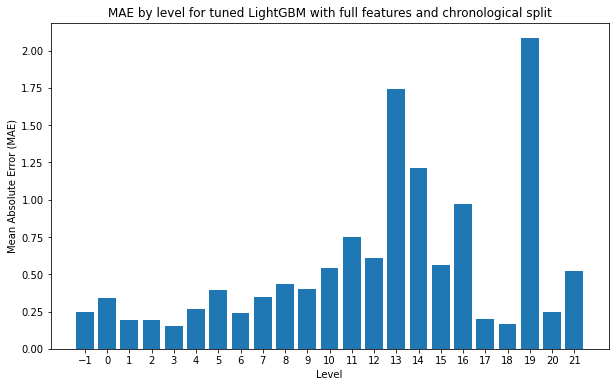

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.63

Round type: round
RMSE: 0.68

Round type: 0.33
RMSE: 0.60

Round type: 0.45
RMSE: 0.65



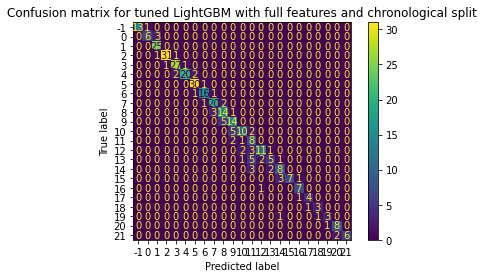

In [29]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with full features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.246737	valid_0's l2: 0.1379


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.37
MAE: 0.25


In [33]:
results.loc[2] = ["random", "default", "full", rmse, mae]

###### MAE by level

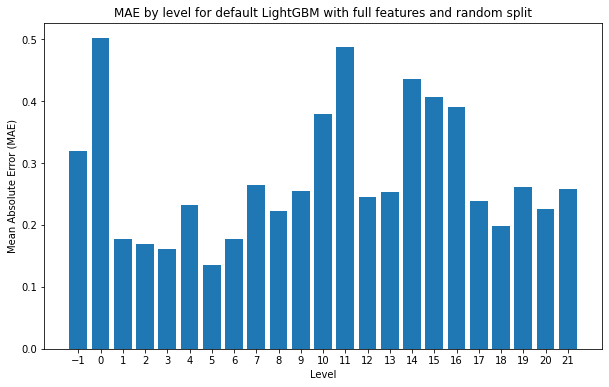

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and random split",
)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.37

Round type: round
RMSE: 0.38

Round type: 0.33
RMSE: 0.43

Round type: 0.45
RMSE: 0.38



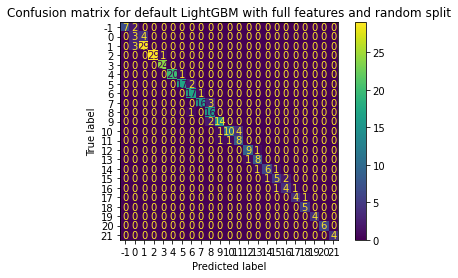

In [36]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with full features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 12:47:06,032] A new study created in memory with name: no-name-c3776b3a-5bf4-4121-a9b9-a584d02e4edd
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.170019 + 0.0535297
[200]	cv_agg's l2: 0.167321 + 0.0512705
[300]	cv_agg's l2: 0.166338 + 0.0500137
[400]	cv_agg's l2: 0.165673 + 0.048914
[500]	cv_agg's l2: 0.165243 + 0.0484187
[600]	cv_agg's l2: 0.165033 + 0.0481282
[700]	cv_agg's l2: 0.16497 + 0.0480635
[800]	cv_agg's l2: 0.164875 + 0.0480185
[900]	cv_agg's l2: 0.164793 + 0.0479648
[1000]	cv_agg's l2: 0.164775 + 0.0479472


feature_fraction, val_score: 0.164769:  14%|######4                                      | 1/7 [00:06<00:38,  6.50s/it]

[1100]	cv_agg's l2: 0.164785 + 0.0479465
Early stopping, best iteration is:
[1016]	cv_agg's l2: 0.164769 + 0.0479291
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139046 + 0.0193156
[1100]	cv_agg's l2: 0.139032 + 0.0193225
[1200]	cv_agg's l2: 0.138976 + 0.019336
[1300]	cv_agg's l2: 0.13893 + 0.0193193
[1400]	cv_agg's l2: 0.138917 + 0.0193098


feature_fraction, val_score: 0.138910:  29%|############8                                | 2/7 [00:19<00:51, 10.39s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.154721 + 0.0245814
[200]	cv_agg's l2: 0.150806 + 0.0234789
[300]	cv_agg's l2: 0.150039 + 0.0232775
[400]	cv_agg's l2: 0.149408 + 0.0228823
[500]	cv_agg's l2: 0.148855 + 0.0225708
[600]	cv_agg's l2: 0.148766 + 0.0224291
[700]	cv_agg's l2: 0.14858 + 0.0223809
[800]	cv_agg's l2: 0.14849 + 0.0223332
[900]	cv_agg's l2: 0.148411 + 0.0223147
[1000]	cv_agg's l2: 0.148349 + 0.022307
[1100]	cv_agg's l2: 0.148315 + 0.0222827
[1200]	cv_agg's l2: 0.148333 + 0.0223009
[1300]	cv_agg's l2: 0.148345 + 0.0223165
[1400]	cv_agg's l2: 0.148352 + 0.0223179


feature_fraction, val_score: 0.138910:  43%|###################2                         | 3/7 [00:29<00:40, 10.13s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.16542 + 0.0516656
[200]	cv_agg's l2: 0.160834 + 0.0491199
[300]	cv_agg's l2: 0.159854 + 0.0480067
[400]	cv_agg's l2: 0.159587 + 0.047579
[500]	cv_agg's l2: 0.159513 + 0.0472735
[600]	cv_agg's l2: 0.159598 + 0.0471779
[700]	cv_agg's l2: 0.159568 + 0.0471626
[800]	cv_agg's l2: 0.159604 + 0.047127
[900]	cv_agg's l2: 0.159608 + 0.0470322
[1000]	cv_agg's l2: 0.159625 + 0.0469946
[1100]	cv_agg's l2: 0.159616 + 0.0469423
[1200]	cv_agg's l2: 0.159636 + 0.046915
[1300]	cv_agg's l2: 0.159669 + 0.0468881
[1400]	cv_agg's l2: 0.159695 + 0.0468845


feature_fraction, val_score: 0.138910:  57%|#########################7                   | 4/7 [00:40<00:31, 10.58s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.17296 + 0.0492151
[200]	cv_agg's l2: 0.16883 + 0.046995
[300]	cv_agg's l2: 0.168456 + 0.0462632
[400]	cv_agg's l2: 0.167919 + 0.0458558
[500]	cv_agg's l2: 0.16771 + 0.045463
[600]	cv_agg's l2: 0.167736 + 0.0452154
[700]	cv_agg's l2: 0.167664 + 0.0450023
[800]	cv_agg's l2: 0.167645 + 0.0448276
[900]	cv_agg's l2: 0.167622 + 0.0447179
[1000]	cv_agg's l2: 0.167626 + 0.0446352
[1100]	cv_agg's l2: 0.16768 + 0.0446224
[1200]	cv_agg's l2: 0.167731 + 0.0446364
[1300]	cv_agg's l2: 0.167742 + 0.0446114
[1400]	cv_agg's l2: 0.167762 + 0.0446176


feature_fraction, val_score: 0.138910:  71%|################################1            | 5/7 [00:50<00:20, 10.45s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.172377 + 0.0397532
[200]	cv_agg's l2: 0.168498 + 0.0377503
[300]	cv_agg's l2: 0.167595 + 0.0375984
[400]	cv_agg's l2: 0.167074 + 0.0372104
[500]	cv_agg's l2: 0.167048 + 0.036957
[600]	cv_agg's l2: 0.167118 + 0.036831
[700]	cv_agg's l2: 0.167049 + 0.036733
[800]	cv_agg's l2: 0.166998 + 0.0366605
[900]	cv_agg's l2: 0.16702 + 0.0365834
[1000]	cv_agg's l2: 0.167008 + 0.0365164
[1100]	cv_agg's l2: 0.166961 + 0.0364114
[1200]	cv_agg's l2: 0.166916 + 0.036341
[1300]	cv_agg's l2: 0.166912 + 0.0363021
[1400]	cv_agg's l2: 0.166914 + 0.0362878


feature_fraction, val_score: 0.138910:  86%|######################################5      | 6/7 [01:02<00:10, 10.82s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.144204 + 0.0236616
[200]	cv_agg's l2: 0.141978 + 0.0235058
[300]	cv_agg's l2: 0.141442 + 0.0241937
[400]	cv_agg's l2: 0.141074 + 0.023954
[500]	cv_agg's l2: 0.140804 + 0.0239369
[600]	cv_agg's l2: 0.14054 + 0.0237426
[700]	cv_agg's l2: 0.140432 + 0.0236117
[800]	cv_agg's l2: 0.140237 + 0.0236123
[900]	cv_agg's l2: 0.140238 + 0.023641
[1000]	cv_agg's l2: 0.140205 + 0.0236286
[1100]	cv_agg's l2: 0.140136 + 0.0236216
[1200]	cv_agg's l2: 0.140131 + 0.0236275
[1300]	cv_agg's l2: 0.140111 + 0.0236111
[1400]	cv_agg's l2: 0.140106 + 0.0236151


feature_fraction, val_score: 0.138910: 100%|#############################################| 7/7 [01:11<00:00, 10.25s/it]


Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004


num_leaves, val_score: 0.138910:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:   5%|##5                                               | 1/20 [00:11<03:32, 11.17s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  10%|#####                                             | 2/20 [00:23<03:31, 11.74s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  15%|#######5                                          | 3/20 [00:33<03:08, 11.06s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.153403 + 0.0333904
[200]	cv_agg's l2: 0.146584 + 0.0316596
[300]	cv_agg's l2: 0.143996 + 0.0309525
[400]	cv_agg's l2: 0.142735 + 0.0300418
[500]	cv_agg's l2: 0.141551 + 0.0286736
[600]	cv_agg's l2: 0.141694 + 0.0282299
[700]	cv_agg's l2: 0.141512 + 0.0277644
[800]	cv_agg's l2: 0.141507 + 0.0275447
[900]	cv_agg's l2: 0.141402 + 0.0271158
[1000]	cv_agg's l2: 0.141055 + 0.026957
[1100]	cv_agg's l2: 0.141219 + 0.0266651
[1200]	cv_agg's l2: 0.141175 + 0.0263962
[1300]	cv_agg's l2: 0.140905 + 0.0263701
[1400]	cv_agg's l2: 0.140839 + 0.0260482


num_leaves, val_score: 0.138910:  20%|##########                                        | 4/20 [00:39<02:21,  8.85s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  25%|############5                                     | 5/20 [00:49<02:23,  9.54s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  30%|###############                                   | 6/20 [01:00<02:17,  9.81s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  35%|#################5                                | 7/20 [01:10<02:10, 10.04s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  40%|####################                              | 8/20 [01:20<01:58,  9.91s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  45%|######################5                           | 9/20 [01:31<01:52, 10.23s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  50%|########################5                        | 10/20 [01:42<01:46, 10.69s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  55%|##########################9                      | 11/20 [01:55<01:40, 11.17s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  60%|#############################4                   | 12/20 [02:05<01:28, 11.03s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  65%|###############################8                 | 13/20 [02:25<01:34, 13.55s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  70%|##################################3              | 14/20 [02:41<01:25, 14.23s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  75%|####################################7            | 15/20 [02:53<01:07, 13.58s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  80%|#######################################2         | 16/20 [03:04<00:51, 12.81s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  85%|#########################################6       | 17/20 [03:15<00:36, 12.30s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  90%|############################################1    | 18/20 [03:25<00:23, 11.74s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910:  95%|##############################################5  | 19/20 [03:36<00:11, 11.35s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139065 + 0.0193256
[1100]	cv_agg's l2: 0.139053 + 0.0193333
[1200]	cv_agg's l2: 0.138989 + 0.0193426
[1300]	cv_agg's l2: 0.13895 + 0.0193278
[1400]	cv_agg's l2: 0.138951 + 0.0193368


num_leaves, val_score: 0.138910: 100%|#################################################| 20/20 [03:46<00:00, 11.32s/it]


Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004


bagging, val_score: 0.138910:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.158631 + 0.0148811
[200]	cv_agg's l2: 0.152513 + 0.0159581
[300]	cv_agg's l2: 0.151726 + 0.0149552
[400]	cv_agg's l2: 0.151372 + 0.0155679
[500]	cv_agg's l2: 0.151904 + 0.0154491
[600]	cv_agg's l2: 0.151376 + 0.0160674
[700]	cv_agg's l2: 0.150906 + 0.0160809
[800]	cv_agg's l2: 0.151102 + 0.0158225
[900]	cv_agg's l2: 0.150603 + 0.0160924
[1000]	cv_agg's l2: 0.150747 + 0.0162008
[1100]	cv_agg's l2: 0.150645 + 0.0162329
[1200]	cv_agg's l2: 0.150326 + 0.0159878
[1300]	cv_agg's l2: 0.150266 + 0.0159706
[1400]	cv_agg's l2: 0.15018 + 0.0159988


bagging, val_score: 0.138910:  10%|#####3                                               | 1/10 [00:07<01:11,  7.98s/it]

Early stopping, best iteration is:
[1385]	cv_agg's l2: 0.13891 + 0.0193004
[100]	cv_agg's l2: 0.143612 + 0.0199061
[200]	cv_agg's l2: 0.139222 + 0.0197203
[300]	cv_agg's l2: 0.137901 + 0.0206352
[400]	cv_agg's l2: 0.137869 + 0.0209169
[500]	cv_agg's l2: 0.137772 + 0.0212041
[600]	cv_agg's l2: 0.137489 + 0.0212694
[700]	cv_agg's l2: 0.137292 + 0.0211261
[800]	cv_agg's l2: 0.13719 + 0.0210394
[900]	cv_agg's l2: 0.13715 + 0.0211198


bagging, val_score: 0.137125:  20%|##########6                                          | 2/10 [00:14<00:57,  7.22s/it]

Early stopping, best iteration is:
[873]	cv_agg's l2: 0.137125 + 0.0210851
[100]	cv_agg's l2: 0.146102 + 0.0182736
[200]	cv_agg's l2: 0.142929 + 0.0182823
[300]	cv_agg's l2: 0.142279 + 0.0180679
[400]	cv_agg's l2: 0.141864 + 0.0178141
[500]	cv_agg's l2: 0.141441 + 0.0176953
[600]	cv_agg's l2: 0.141308 + 0.0176352
[700]	cv_agg's l2: 0.14119 + 0.0176394
[800]	cv_agg's l2: 0.141143 + 0.0176914
[900]	cv_agg's l2: 0.141085 + 0.0177248


bagging, val_score: 0.137125:  30%|###############9                                     | 3/10 [00:21<00:49,  7.04s/it]

Early stopping, best iteration is:
[873]	cv_agg's l2: 0.137125 + 0.0210851
[100]	cv_agg's l2: 0.145114 + 0.0200834
[200]	cv_agg's l2: 0.139849 + 0.0201849
[300]	cv_agg's l2: 0.138725 + 0.0200739
[400]	cv_agg's l2: 0.138027 + 0.0197737
[500]	cv_agg's l2: 0.137899 + 0.0200317
[600]	cv_agg's l2: 0.137757 + 0.0199015
[700]	cv_agg's l2: 0.137619 + 0.01987
[800]	cv_agg's l2: 0.137449 + 0.0197025
[900]	cv_agg's l2: 0.137398 + 0.0196214


bagging, val_score: 0.137125:  40%|#####################2                               | 4/10 [00:28<00:41,  6.89s/it]

Early stopping, best iteration is:
[873]	cv_agg's l2: 0.137125 + 0.0210851
[100]	cv_agg's l2: 0.14383 + 0.0195703
[200]	cv_agg's l2: 0.138817 + 0.0178812
[300]	cv_agg's l2: 0.137869 + 0.0173857
[400]	cv_agg's l2: 0.137462 + 0.0174249
[500]	cv_agg's l2: 0.137436 + 0.0172999
[600]	cv_agg's l2: 0.137228 + 0.017272
[700]	cv_agg's l2: 0.136919 + 0.0171979
[800]	cv_agg's l2: 0.136797 + 0.0171937
[900]	cv_agg's l2: 0.136774 + 0.0171969
[1000]	cv_agg's l2: 0.136712 + 0.0171836
[1100]	cv_agg's l2: 0.136675 + 0.017229
[1200]	cv_agg's l2: 0.136649 + 0.0172348
[1300]	cv_agg's l2: 0.136629 + 0.0172451
[1400]	cv_agg's l2: 0.136609 + 0.0172528


bagging, val_score: 0.136598:  50%|##########################5                          | 5/10 [00:38<00:40,  8.00s/it]

Early stopping, best iteration is:
[1386]	cv_agg's l2: 0.136598 + 0.0172478
[100]	cv_agg's l2: 0.145184 + 0.0167022
[200]	cv_agg's l2: 0.140176 + 0.0166117
[300]	cv_agg's l2: 0.139032 + 0.0170146
[400]	cv_agg's l2: 0.138277 + 0.0170092
[500]	cv_agg's l2: 0.137946 + 0.0168518
[600]	cv_agg's l2: 0.137836 + 0.0167976
[700]	cv_agg's l2: 0.137717 + 0.0167803
[800]	cv_agg's l2: 0.137614 + 0.0167531
[900]	cv_agg's l2: 0.13751 + 0.0167561
[1000]	cv_agg's l2: 0.137413 + 0.0166513
[1100]	cv_agg's l2: 0.137345 + 0.0166031
[1200]	cv_agg's l2: 0.137331 + 0.0165996
[1300]	cv_agg's l2: 0.137316 + 0.0166167
[1400]	cv_agg's l2: 0.13729 + 0.0166236


bagging, val_score: 0.136598:  60%|###############################8                     | 6/10 [00:48<00:34,  8.67s/it]

Early stopping, best iteration is:
[1386]	cv_agg's l2: 0.136598 + 0.0172478
[100]	cv_agg's l2: 0.14577 + 0.0190072
[200]	cv_agg's l2: 0.141968 + 0.0190092
[300]	cv_agg's l2: 0.140393 + 0.0187957
[400]	cv_agg's l2: 0.139954 + 0.0192357
[500]	cv_agg's l2: 0.139775 + 0.0192077
[600]	cv_agg's l2: 0.139566 + 0.0192705
[700]	cv_agg's l2: 0.139304 + 0.0191916
[800]	cv_agg's l2: 0.139179 + 0.0192118
[900]	cv_agg's l2: 0.139131 + 0.0193297
[1000]	cv_agg's l2: 0.139046 + 0.0193156
[1100]	cv_agg's l2: 0.139032 + 0.0193225
[1200]	cv_agg's l2: 0.138976 + 0.019336
[1300]	cv_agg's l2: 0.13893 + 0.0193193
[1400]	cv_agg's l2: 0.138917 + 0.0193098


bagging, val_score: 0.136598:  70%|#####################################                | 7/10 [00:58<00:27,  9.17s/it]

Early stopping, best iteration is:
[1386]	cv_agg's l2: 0.136598 + 0.0172478
[100]	cv_agg's l2: 0.146184 + 0.0186254
[200]	cv_agg's l2: 0.140677 + 0.0167891
[300]	cv_agg's l2: 0.139879 + 0.0168274
[400]	cv_agg's l2: 0.139268 + 0.0166101
[500]	cv_agg's l2: 0.13861 + 0.0168301
[600]	cv_agg's l2: 0.138358 + 0.0167063
[700]	cv_agg's l2: 0.138118 + 0.0167646
[800]	cv_agg's l2: 0.138043 + 0.0168388
[900]	cv_agg's l2: 0.137961 + 0.0168799
[1000]	cv_agg's l2: 0.137897 + 0.0168755
[1100]	cv_agg's l2: 0.137826 + 0.0168702
[1200]	cv_agg's l2: 0.137769 + 0.016877
[1300]	cv_agg's l2: 0.137753 + 0.0168904
[1400]	cv_agg's l2: 0.13775 + 0.0168863


bagging, val_score: 0.136598:  80%|##########################################4          | 8/10 [01:08<00:18,  9.39s/it]

Early stopping, best iteration is:
[1386]	cv_agg's l2: 0.136598 + 0.0172478
[100]	cv_agg's l2: 0.142588 + 0.018054
[200]	cv_agg's l2: 0.138676 + 0.018368
[300]	cv_agg's l2: 0.137548 + 0.0180764
[400]	cv_agg's l2: 0.136758 + 0.0183788
[500]	cv_agg's l2: 0.136399 + 0.0182881
[600]	cv_agg's l2: 0.136159 + 0.0182854
[700]	cv_agg's l2: 0.136092 + 0.0183207
[800]	cv_agg's l2: 0.136011 + 0.0183645
[900]	cv_agg's l2: 0.13594 + 0.0183683
[1000]	cv_agg's l2: 0.135859 + 0.0183307
[1100]	cv_agg's l2: 0.135794 + 0.0183346
[1200]	cv_agg's l2: 0.135772 + 0.0183563
[1300]	cv_agg's l2: 0.135739 + 0.0183372
[1400]	cv_agg's l2: 0.135713 + 0.0183318
[1500]	cv_agg's l2: 0.135702 + 0.018319
[1600]	cv_agg's l2: 0.135688 + 0.0183318


bagging, val_score: 0.135678:  90%|###############################################7     | 9/10 [01:19<00:10, 10.01s/it]

Early stopping, best iteration is:
[1549]	cv_agg's l2: 0.135678 + 0.0183184
[100]	cv_agg's l2: 0.143764 + 0.0262345
[200]	cv_agg's l2: 0.137758 + 0.0234234
[300]	cv_agg's l2: 0.136567 + 0.0230436
[400]	cv_agg's l2: 0.135876 + 0.0228534
[500]	cv_agg's l2: 0.135718 + 0.022682
[600]	cv_agg's l2: 0.135509 + 0.0225784
[700]	cv_agg's l2: 0.135491 + 0.0227669


bagging, val_score: 0.135387: 100%|####################################################| 10/10 [01:24<00:00,  8.44s/it]


Early stopping, best iteration is:
[637]	cv_agg's l2: 0.135387 + 0.0226196


feature_fraction_stage2, val_score: 0.135387:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.146938 + 0.0287256
[200]	cv_agg's l2: 0.14408 + 0.0271484
[300]	cv_agg's l2: 0.142625 + 0.0263282
[400]	cv_agg's l2: 0.141803 + 0.0255563
[500]	cv_agg's l2: 0.141608 + 0.0251992
[600]	cv_agg's l2: 0.141553 + 0.0250003
[700]	cv_agg's l2: 0.141398 + 0.0249137


feature_fraction_stage2, val_score: 0.135387:  33%|############6                         | 1/3 [00:04<00:09,  4.87s/it]

Early stopping, best iteration is:
[637]	cv_agg's l2: 0.135387 + 0.0226196
[100]	cv_agg's l2: 0.144264 + 0.0270562
[200]	cv_agg's l2: 0.137382 + 0.0251488
[300]	cv_agg's l2: 0.136162 + 0.0246162
[400]	cv_agg's l2: 0.135543 + 0.0245898
[500]	cv_agg's l2: 0.134994 + 0.0249209
[600]	cv_agg's l2: 0.13486 + 0.0245498
[700]	cv_agg's l2: 0.134751 + 0.0246209


feature_fraction_stage2, val_score: 0.134624:  67%|#########################3            | 2/3 [00:09<00:04,  4.95s/it]

Early stopping, best iteration is:
[672]	cv_agg's l2: 0.134624 + 0.0245059
[100]	cv_agg's l2: 0.143925 + 0.0246891
[200]	cv_agg's l2: 0.139631 + 0.0234055
[300]	cv_agg's l2: 0.1384 + 0.023015
[400]	cv_agg's l2: 0.138445 + 0.0226175
[500]	cv_agg's l2: 0.138049 + 0.0222906
[600]	cv_agg's l2: 0.137871 + 0.0223054
[700]	cv_agg's l2: 0.137809 + 0.0221626


feature_fraction_stage2, val_score: 0.134624: 100%|######################################| 3/3 [00:14<00:00,  4.94s/it]


Early stopping, best iteration is:
[672]	cv_agg's l2: 0.134624 + 0.0245059


regularization_factors, val_score: 0.134624:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.141945 + 0.0243008
[200]	cv_agg's l2: 0.138392 + 0.0247385
[300]	cv_agg's l2: 0.137126 + 0.0240259
[400]	cv_agg's l2: 0.136749 + 0.0241404
[500]	cv_agg's l2: 0.136462 + 0.0241891
[600]	cv_agg's l2: 0.136182 + 0.0239326
[700]	cv_agg's l2: 0.13626 + 0.0239897


regularization_factors, val_score: 0.134624:   5%|#9                                    | 1/20 [00:04<01:33,  4.92s/it]

Early stopping, best iteration is:
[672]	cv_agg's l2: 0.134624 + 0.0245059
[100]	cv_agg's l2: 0.14297 + 0.0252124
[200]	cv_agg's l2: 0.138814 + 0.0248181
[300]	cv_agg's l2: 0.137507 + 0.0240267
[400]	cv_agg's l2: 0.137015 + 0.0238194
[500]	cv_agg's l2: 0.13666 + 0.0241067
[600]	cv_agg's l2: 0.136481 + 0.0240105
[700]	cv_agg's l2: 0.136551 + 0.0240699


regularization_factors, val_score: 0.134624:  10%|###8                                  | 2/20 [00:09<01:27,  4.84s/it]

Early stopping, best iteration is:
[672]	cv_agg's l2: 0.134624 + 0.0245059
[100]	cv_agg's l2: 0.140104 + 0.0251248
[200]	cv_agg's l2: 0.135622 + 0.0243937
[300]	cv_agg's l2: 0.134167 + 0.0233031
[400]	cv_agg's l2: 0.133977 + 0.0231999
Early stopping, best iteration is:
[329]	cv_agg's l2: 0.133755 + 0.0232107


regularization_factors, val_score: 0.133755:  15%|#####7                                | 3/20 [00:12<01:07,  3.94s/it]

[100]	cv_agg's l2: 0.140274 + 0.0251954
[200]	cv_agg's l2: 0.136034 + 0.0242353
[300]	cv_agg's l2: 0.134808 + 0.0236908
[400]	cv_agg's l2: 0.134431 + 0.023545


regularization_factors, val_score: 0.133755:  20%|#######6                              | 4/20 [00:15<00:56,  3.54s/it]

Early stopping, best iteration is:
[329]	cv_agg's l2: 0.133755 + 0.0232107
[100]	cv_agg's l2: 0.143072 + 0.0277422
[200]	cv_agg's l2: 0.13866 + 0.0264296
[300]	cv_agg's l2: 0.137137 + 0.0259311


regularization_factors, val_score: 0.133755:  20%|#######6                              | 4/20 [00:18<00:56,  3.54s/it]

[400]	cv_agg's l2: 0.136618 + 0.0258641
Early stopping, best iteration is:
[329]	cv_agg's l2: 0.133755 + 0.0232107


regularization_factors, val_score: 0.133755:  25%|#########5                            | 5/20 [00:18<00:49,  3.32s/it]

[100]	cv_agg's l2: 0.169464 + 0.0357468
[200]	cv_agg's l2: 0.159772 + 0.0346513
[300]	cv_agg's l2: 0.156911 + 0.034979


regularization_factors, val_score: 0.133755:  30%|###########4                          | 6/20 [00:19<00:37,  2.68s/it]

[400]	cv_agg's l2: 0.156208 + 0.0349757
Early stopping, best iteration is:
[329]	cv_agg's l2: 0.133755 + 0.0232107
[100]	cv_agg's l2: 0.140359 + 0.0279398
[200]	cv_agg's l2: 0.13602 + 0.0259934
[300]	cv_agg's l2: 0.134336 + 0.0256832
[400]	cv_agg's l2: 0.134192 + 0.0254054


regularization_factors, val_score: 0.133755:  35%|#############3                        | 7/20 [00:22<00:35,  2.75s/it]

Early stopping, best iteration is:
[329]	cv_agg's l2: 0.133755 + 0.0232107
[100]	cv_agg's l2: 0.142572 + 0.0214062
[200]	cv_agg's l2: 0.136095 + 0.0211273
[300]	cv_agg's l2: 0.134989 + 0.0208602


regularization_factors, val_score: 0.133755:  35%|#############3                        | 7/20 [00:25<00:35,  2.75s/it]

[400]	cv_agg's l2: 0.134208 + 0.0209557
Early stopping, best iteration is:
[329]	cv_agg's l2: 0.133755 + 0.0232107


regularization_factors, val_score: 0.133755:  40%|###############2                      | 8/20 [00:25<00:33,  2.79s/it]

[100]	cv_agg's l2: 0.141503 + 0.0270013
[200]	cv_agg's l2: 0.136336 + 0.0256791
[300]	cv_agg's l2: 0.135018 + 0.0255068


regularization_factors, val_score: 0.133755:  40%|###############2                      | 8/20 [00:28<00:33,  2.79s/it]

[400]	cv_agg's l2: 0.134851 + 0.0253068
Early stopping, best iteration is:
[329]	cv_agg's l2: 0.133755 + 0.0232107


regularization_factors, val_score: 0.133755:  45%|#################1                    | 9/20 [00:28<00:31,  2.84s/it]

[100]	cv_agg's l2: 0.138437 + 0.0233532
[200]	cv_agg's l2: 0.133351 + 0.0213705
[300]	cv_agg's l2: 0.131986 + 0.02167
[400]	cv_agg's l2: 0.131974 + 0.0223403
[500]	cv_agg's l2: 0.131461 + 0.0223821
[600]	cv_agg's l2: 0.131326 + 0.0223623
[700]	cv_agg's l2: 0.131262 + 0.0224559


regularization_factors, val_score: 0.131207:  50%|##################5                  | 10/20 [00:33<00:35,  3.51s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.139722 + 0.024095
[200]	cv_agg's l2: 0.135064 + 0.0216832
[300]	cv_agg's l2: 0.134209 + 0.0212773
[400]	cv_agg's l2: 0.13322 + 0.0213704
[500]	cv_agg's l2: 0.132976 + 0.0212245
[600]	cv_agg's l2: 0.132784 + 0.021096
[700]	cv_agg's l2: 0.132836 + 0.0210735


regularization_factors, val_score: 0.131207:  55%|####################3                | 11/20 [00:38<00:36,  4.04s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.14017 + 0.0260889
[200]	cv_agg's l2: 0.135877 + 0.0253585
[300]	cv_agg's l2: 0.134725 + 0.0258841
[400]	cv_agg's l2: 0.134619 + 0.0257518
[500]	cv_agg's l2: 0.134101 + 0.0256831
[600]	cv_agg's l2: 0.133711 + 0.0253873
[700]	cv_agg's l2: 0.133534 + 0.025405


regularization_factors, val_score: 0.131207:  60%|######################2              | 12/20 [00:43<00:34,  4.31s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.140265 + 0.0230659
[200]	cv_agg's l2: 0.136079 + 0.0229268
[300]	cv_agg's l2: 0.135251 + 0.0235633
[400]	cv_agg's l2: 0.134565 + 0.0237187
[500]	cv_agg's l2: 0.134229 + 0.0238744
[600]	cv_agg's l2: 0.134227 + 0.0238236
[700]	cv_agg's l2: 0.134086 + 0.0236083


regularization_factors, val_score: 0.131207:  65%|########################             | 13/20 [00:48<00:31,  4.51s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.139495 + 0.0232003
[200]	cv_agg's l2: 0.134929 + 0.0221383
[300]	cv_agg's l2: 0.13321 + 0.0216998
[400]	cv_agg's l2: 0.133325 + 0.0208632
[500]	cv_agg's l2: 0.133022 + 0.0207879
[600]	cv_agg's l2: 0.1326 + 0.020793
[700]	cv_agg's l2: 0.132481 + 0.0205354


regularization_factors, val_score: 0.131207:  70%|#########################9           | 14/20 [00:53<00:27,  4.63s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.142071 + 0.0256382
[200]	cv_agg's l2: 0.137069 + 0.0260501
[300]	cv_agg's l2: 0.135865 + 0.0248302
[400]	cv_agg's l2: 0.135907 + 0.0245436
[500]	cv_agg's l2: 0.135633 + 0.0245413
[600]	cv_agg's l2: 0.135477 + 0.0243763
[700]	cv_agg's l2: 0.135361 + 0.0244177


regularization_factors, val_score: 0.131207:  75%|###########################7         | 15/20 [00:58<00:23,  4.73s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.140194 + 0.0247049
[200]	cv_agg's l2: 0.134803 + 0.0223448
[300]	cv_agg's l2: 0.134312 + 0.022407
[400]	cv_agg's l2: 0.133945 + 0.0222338
[500]	cv_agg's l2: 0.133188 + 0.022196
[600]	cv_agg's l2: 0.133246 + 0.0223205
[700]	cv_agg's l2: 0.133241 + 0.0223877


regularization_factors, val_score: 0.131207:  80%|#############################6       | 16/20 [01:03<00:19,  4.86s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.139974 + 0.0251884
[200]	cv_agg's l2: 0.135718 + 0.0264247
[300]	cv_agg's l2: 0.134541 + 0.0251023
[400]	cv_agg's l2: 0.133966 + 0.0248586
[500]	cv_agg's l2: 0.133587 + 0.0251864
[600]	cv_agg's l2: 0.133588 + 0.0252215
[700]	cv_agg's l2: 0.133432 + 0.0251177


regularization_factors, val_score: 0.131207:  85%|###############################4     | 17/20 [01:08<00:14,  4.96s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.141793 + 0.0271222
[200]	cv_agg's l2: 0.135211 + 0.0258264
[300]	cv_agg's l2: 0.134239 + 0.025097
[400]	cv_agg's l2: 0.134003 + 0.0250921
[500]	cv_agg's l2: 0.133936 + 0.0249526
[600]	cv_agg's l2: 0.133495 + 0.0244977
[700]	cv_agg's l2: 0.133417 + 0.02455


regularization_factors, val_score: 0.131207:  90%|#################################3   | 18/20 [01:13<00:09,  4.96s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.142239 + 0.0263487
[200]	cv_agg's l2: 0.13828 + 0.0256946
[300]	cv_agg's l2: 0.136854 + 0.0249772
[400]	cv_agg's l2: 0.136159 + 0.0248539
[500]	cv_agg's l2: 0.135394 + 0.0247344
[600]	cv_agg's l2: 0.135391 + 0.0245902
[700]	cv_agg's l2: 0.135263 + 0.0243699


regularization_factors, val_score: 0.131207:  95%|###################################1 | 19/20 [01:18<00:04,  4.92s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.169259 + 0.0337092
[200]	cv_agg's l2: 0.157618 + 0.0333116
[300]	cv_agg's l2: 0.154391 + 0.0321316
[400]	cv_agg's l2: 0.152968 + 0.0322594
[500]	cv_agg's l2: 0.152287 + 0.0321573
[600]	cv_agg's l2: 0.151764 + 0.032353
[700]	cv_agg's l2: 0.151513 + 0.0325069


regularization_factors, val_score: 0.131207: 100%|#####################################| 20/20 [01:23<00:00,  4.17s/it]


Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327


min_data_in_leaf, val_score: 0.131207:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.800732 + 0.0965133
[200]	cv_agg's l2: 0.759242 + 0.0992302
[300]	cv_agg's l2: 0.734217 + 0.103485
[400]	cv_agg's l2: 0.719244 + 0.100084
[500]	cv_agg's l2: 0.706956 + 0.0929245
[600]	cv_agg's l2: 0.706764 + 0.0915373


min_data_in_leaf, val_score: 0.131207:  20%|#########                                    | 1/5 [00:02<00:08,  2.15s/it]

[700]	cv_agg's l2: 0.697941 + 0.0906987
Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.247619 + 0.0349065
[200]	cv_agg's l2: 0.233134 + 0.0275524
[300]	cv_agg's l2: 0.226167 + 0.0238621
[400]	cv_agg's l2: 0.223473 + 0.0211321
[500]	cv_agg's l2: 0.223889 + 0.0200012
[600]	cv_agg's l2: 0.226035 + 0.0192759


min_data_in_leaf, val_score: 0.131207:  40%|##################                           | 2/5 [00:05<00:07,  2.63s/it]

[700]	cv_agg's l2: 0.226337 + 0.0183866
Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.153179 + 0.0245763
[200]	cv_agg's l2: 0.148171 + 0.0227625
[300]	cv_agg's l2: 0.146236 + 0.0211398
[400]	cv_agg's l2: 0.145572 + 0.0204323
[500]	cv_agg's l2: 0.144286 + 0.0200017
[600]	cv_agg's l2: 0.144248 + 0.0202437
[700]	cv_agg's l2: 0.144152 + 0.0207082
Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327


min_data_in_leaf, val_score: 0.131207:  60%|###########################                  | 3/5 [00:09<00:06,  3.36s/it]

[100]	cv_agg's l2: 0.136391 + 0.0148835
[200]	cv_agg's l2: 0.133865 + 0.0154325
[300]	cv_agg's l2: 0.1332 + 0.0149746
[400]	cv_agg's l2: 0.133083 + 0.0147527
[500]	cv_agg's l2: 0.133 + 0.0147511
[600]	cv_agg's l2: 0.133022 + 0.0147269
[700]	cv_agg's l2: 0.132988 + 0.0146849


min_data_in_leaf, val_score: 0.131207:  80%|####################################         | 4/5 [00:15<00:04,  4.43s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327
[100]	cv_agg's l2: 0.142614 + 0.0166391
[200]	cv_agg's l2: 0.140712 + 0.0167712
[300]	cv_agg's l2: 0.140355 + 0.0171058
[400]	cv_agg's l2: 0.140343 + 0.017067
[500]	cv_agg's l2: 0.140315 + 0.0170799
[600]	cv_agg's l2: 0.140301 + 0.0170663
[700]	cv_agg's l2: 0.140302 + 0.017065


min_data_in_leaf, val_score: 0.131207: 100%|#############################################| 5/5 [00:21<00:00,  4.35s/it]

Early stopping, best iteration is:
[636]	cv_agg's l2: 0.131207 + 0.0222327


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1312066432263787
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 3.0003803763933366e-08
    lambda_l2: 0.09118255892448525
    num_leaves: 31
    feature_fraction: 0.41600000000000004
    bagging_fraction: 0.8632872598962595
    bagging_freq: 3
    min_child_samples: 20


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.32
MAE test: 0.23



In [41]:
results.loc[3] = ["random", "Optuna", "full", rmse, mae]

###### MAE by level

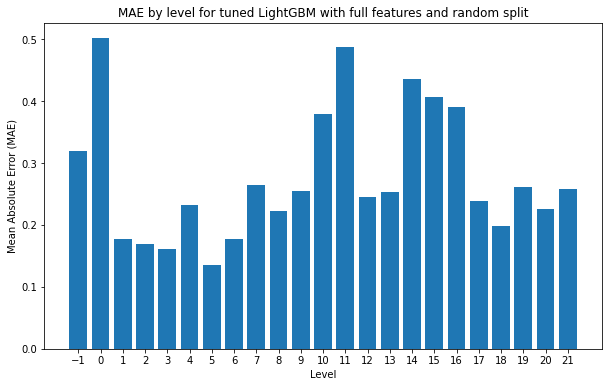

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.18

Round type: round
RMSE: 0.20

Round type: 0.33
RMSE: 0.20

Round type: 0.45
RMSE: 0.20



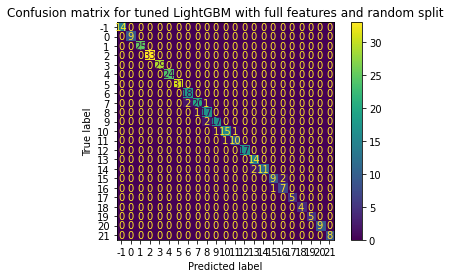

In [44]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with full features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,full,0.965662,0.463517
1,chronological,Optuna,full,0.629814,0.370587
2,random,default,full,0.371349,0.246737
3,random,Optuna,full,0.318295,0.225673


In [46]:
from training.results import plot_summary

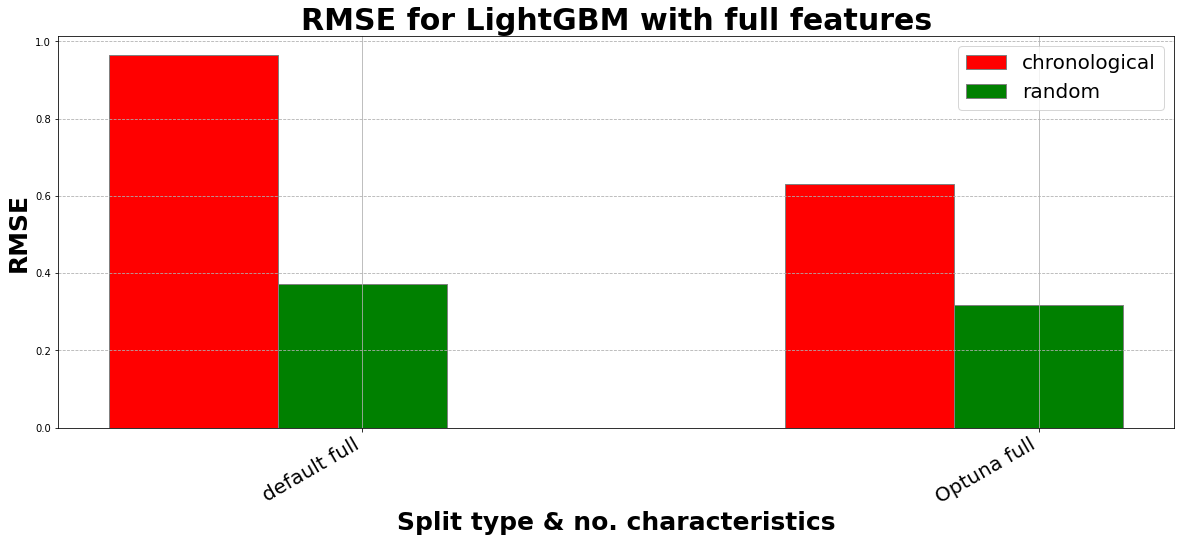

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with full features")

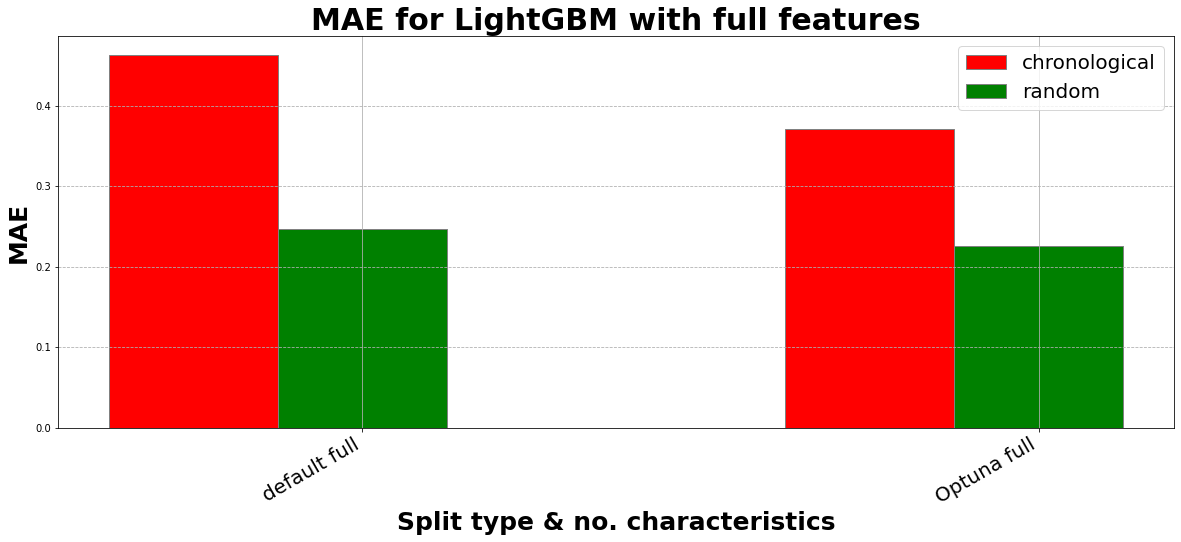

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with full features")

In [49]:
results.to_json("./lightgbm_full_results.json", indent=2)